In [2]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128 && pip install datasets transformers scikit-learn networkx python-louvain tqdm seaborn matplotlib pillow pandas numpy requests faiss-cpu

Looking in indexes: https://download.pytorch.org/whl/cu128
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.2/536.2 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 GB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 609.6/609.6 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 136.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 726.9/726.9 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 133.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 139.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.4/260.4 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.1/292.1 MB 74

In [3]:
! pip install faiss-cpu
import faiss

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 157.1 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import json
import requests
from concurrent.futures import ThreadPoolExecutor
from io import BytesIO
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models, transforms

from transformers import BertTokenizer, BertModel
from datasets import Dataset

import networkx as nx
from community import community_louvain

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [5]:
# Clear cache
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

In [6]:
# Load the original complete data and build HuggingFace Dataset
def load_full_data_to_hf(json_path, sample_frac=0.2):
    with open(json_path) as f:
        data = [json.loads(line) for line in f]
    rows = []
    for entry in data:
        for pic in entry.get('pics', []):
            rows.append({
                'business_id': entry['business_id'],
                'user_id': entry['user_id'],
                'rating': entry['rating'],
                'review_text': entry.get('review_text', ''),
                'pic_url': pic['url'][0]
            })
    df = pd.DataFrame(rows)
    if sample_frac < 1.0:
        df = df.sample(frac=sample_frac, random_state=42).reset_index(drop=True)
    return Dataset.from_pandas(df)

hf_ds = load_full_data_to_hf('/content/drive/MyDrive/CMPE256-Team_Project/dataset/image_review_all.json')


In [7]:
# Batch download pictures to local (using thread pool)
def download_image_task(url, save_path):
    try:
        img_data = requests.get(url, timeout=5).content
        with open(save_path, 'wb') as f:
            f.write(img_data)
    except:
        pass

def batch_download_with_threadpool(urls, save_dir, max_workers=20):
    os.makedirs(save_dir, exist_ok=True)
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = []
        for idx, url in enumerate(urls):
            save_path = os.path.join(save_dir, f"{idx}.jpg")
            futures.append(executor.submit(download_image_task, url, save_path))
        for f in tqdm(futures, desc="Downloading Images"):
            f.result()

image_dir = '/content/drive/MyDrive/CMPE256-Team_Project/full_dataset_images'
df = hf_ds.to_pandas()

if not os.path.exists(image_dir):
    batch_download_with_threadpool(df['pic_url'].tolist(), image_dir)

In [8]:
# Community Detection
g = nx.Graph()
for uid, grp in df.groupby('user_id')['business_id']:
    for b1, b2 in combinations(grp.unique(), 2):
        g.add_edge(b1, b2)
comm_map = community_louvain.best_partition(g)
df['comm'] = df['business_id'].map(comm_map)
le_comm = LabelEncoder()
df['comm_idx'] = le_comm.fit_transform(df['comm'])

In [9]:
# Extract or load features (local cache detection)
img_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
resnet = nn.Sequential(*list(models.resnet18(weights='IMAGENET1K_V1').children())[:-1]).to(DEVICE).eval()

def extract_img_local(path):
    try:
        img = Image.open(path).convert('RGB')
        img_tensor = img_transform(img).unsqueeze(0).to(DEVICE)
        with torch.cuda.amp.autocast(), torch.no_grad():
            feat = resnet(img_tensor).view(-1).cpu().numpy()
        return feat
    except:
        return np.zeros(512)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


In [10]:
# Text feature extraction
class TextCollator:
    def __init__(self, tokenizer, max_len=256):
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __call__(self, batch):
        return self.tokenizer(batch, padding=True, truncation=True, max_length=self.max_len, return_tensors='pt')


In [11]:
# Import BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert = BertModel.from_pretrained('bert-base-uncased').to(DEVICE).eval()

/usr/local/lib/python3.11/site-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [12]:
# Check and load the cache
img_feats_path = '/content/full_img_feats.npz'
text_feats_path = '/content/full_text_feats.npz'
meta_array_path = '/content/meta_array.npz'

In [13]:
# Extract image features
if os.path.exists(img_feats_path):
    print("Loading cached image features...")
    img_feats = np.load(img_feats_path)['img_feats']
else:
    print("Extracting image features from local images...")
    img_feats = []
    for idx in tqdm(range(len(df)), desc="Encoding Local Image Features"):
        path = os.path.join(image_dir, f"{idx}.jpg")
        with torch.amp.autocast('cuda'), torch.no_grad():
            feat = extract_img_local(path)
        img_feats.append(feat)
    img_feats = np.stack(img_feats)
    np.savez_compressed(img_feats_path, img_feats=img_feats)

Loading cached image features...


In [14]:
# Extract text features
if os.path.exists(text_feats_path):
    print("Loading cached text features...")
    text_feats = np.load(text_feats_path)['text_feats']
else:
    print("Extracting text features...")
    text_feats = []
    batch_size = 128
    all_texts = df['review_text'].tolist()

    loader = DataLoader(
        all_texts,
        batch_size=batch_size,
        collate_fn=TextCollator(tokenizer),
        num_workers=0,
    )

    with torch.no_grad():
        for batch in tqdm(loader, desc="Batching Text Features"):
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            output = bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
            text_feats.append(output.cpu().numpy())
    text_feats = np.vstack(text_feats)
    np.savez_compressed(text_feats_path, text_feats=text_feats)


Loading cached text features...


In [15]:
# Combine text and image feature
if os.path.exists(meta_array_path):
    print(f"Found cached meta_array at {meta_array_path}, loading...")
    cache = np.load(meta_array_path)
    meta_array = cache['meta_array']
    print(f"Loaded meta_array, shape: {meta_array.shape}")
else:
    print("Combining image and text features...")

    batch_size = 10000
    meta_batches = []

    for i in tqdm(range(0, len(text_feats), batch_size), desc="Batching Meta Features"):
        text_batch = text_feats[i:i+batch_size]
        img_batch = img_feats[i:i+batch_size]
        meta_batch = np.hstack([text_batch, img_batch])
        meta_batches.append(meta_batch)

    meta_array = np.vstack(meta_batches)

    np.savez_compressed(meta_array_path, meta_array=meta_array)
    print(f"meta_array saved at {meta_array_path}, shape: {meta_array.shape}")

Combining image and text features...


Batching Meta Features: 100%|██████████| 68/68 [00:02<00:00, 32.35it/s]


meta_array saved at /content/meta_array.npz, shape: (670352, 1280)


In [16]:
# Load meta extraction cache
meta_array = np.load('/content/meta_array.npz')['meta_array']
meta_array = meta_array.astype('float32')

In [17]:
# # Constructe the intra-community adjacency matrix
def build_topk_neighbors_faiss(meta_array, df, topk):
    meta_array = meta_array.astype('float32')
    topk_neighbors = np.zeros((len(df), topk), dtype=int)

    for c in df['comm_idx'].unique():
        idx = df[df['comm_idx'] == c].index.tolist()
        if len(idx) <= topk:
            continue

        local_feats = meta_array[idx]

        # Normalize features
        faiss.normalize_L2(local_feats)

        # Build index
        d = local_feats.shape[1]
        index = faiss.IndexFlatIP(d)
        # If already used faiss-gpu, use following code to build GPU index
        # res = faiss.StandardGpuResources()
        # index = faiss.index_cpu_to_gpu(res, 0, index)

        # Add to index
        index.add(local_feats)

        # Search
        D, I = index.search(local_feats, topk + 1)  # include itself
        I = I[:, 1:]  # remove self-match (first column)

        for i, idx_i in enumerate(idx):
            topk_neighbors[idx_i, :] = np.array(idx)[I[i]]

    return topk_neighbors

topk = 10
topk_neighbors = build_topk_neighbors_faiss(meta_array, df, topk)

In [19]:
# Define GAT modules within the community
class GraphAttentionEncoder(nn.Module):
    def __init__(self, in_dim, out_dim, neighbors_matrix):
        super().__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.attn = nn.MultiheadAttention(out_dim, 4, batch_first=True)
        self.norm = nn.LayerNorm(out_dim)
        self.neighbors_matrix = neighbors_matrix

    def forward(self, x):
        x_proj = self.proj(x)
        outs = []
        for i in range(x_proj.shape[0]):
            neighbors = self.neighbors_matrix[i][:topk]
            center = x_proj[i].unsqueeze(0)
            neigh = x_proj[neighbors]
            tokens = torch.cat([center, neigh], dim=0).unsqueeze(0)
            out, _ = self.attn(tokens, tokens, tokens)
            outs.append(self.norm(out[:, 0]))
        return torch.cat(outs, dim=0)

gat_encoder = GraphAttentionEncoder(meta_array.shape[1], 32, topk_neighbors).to(DEVICE)
meta_tensor = torch.tensor(meta_array, dtype=torch.float32).to(DEVICE)
item_emb_matrix = gat_encoder(meta_tensor).detach()


In [20]:
# Extract community tag keywords
community_keywords = {}
for comm in df['comm_idx'].unique():
    texts = df[df['comm_idx'] == comm]['review_text']
    vec = TfidfVectorizer(stop_words='english', max_features=1000)
    tfidf = vec.fit_transform(texts)
    top_words = np.argsort(tfidf.sum(axis=0)).tolist()[0][-10:][::-1]
    keywords = [vec.get_feature_names_out()[i] for i in top_words]
    community_keywords[comm] = keywords

print("\nTop Keywords per Community:")
for k, v in community_keywords.items():
    print(f"Community {k}: {', '.join(v)}")



Top Keywords per Community:
Community 378: food, great, good, service, place, friendly, delicious, staff, best, nice
Community 3: food, great, good, service, place, delicious, amazing, nice, excellent, best
Community 5: food, great, good, place, service, delicious, amazing, original, best, google
Community 8: food, great, good, service, place, delicious, amazing, staff, best, friendly
Community 9: food, great, good, service, place, delicious, amazing, staff, friendly, time
Community 1: food, great, good, service, place, delicious, amazing, best, friendly, original
Community 13: food, great, good, service, place, delicious, amazing, staff, nice, friendly
Community 22: food, good, great, service, place, delicious, burger, amazing, friendly, best
Community 7: food, great, good, service, place, delicious, amazing, best, staff, time
Community 2: food, great, good, service, place, delicious, amazing, best, friendly, staff
Community 0: food, great, good, service, place, delicious, amazing, s

<ipython-input-23-8074876c759c>:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


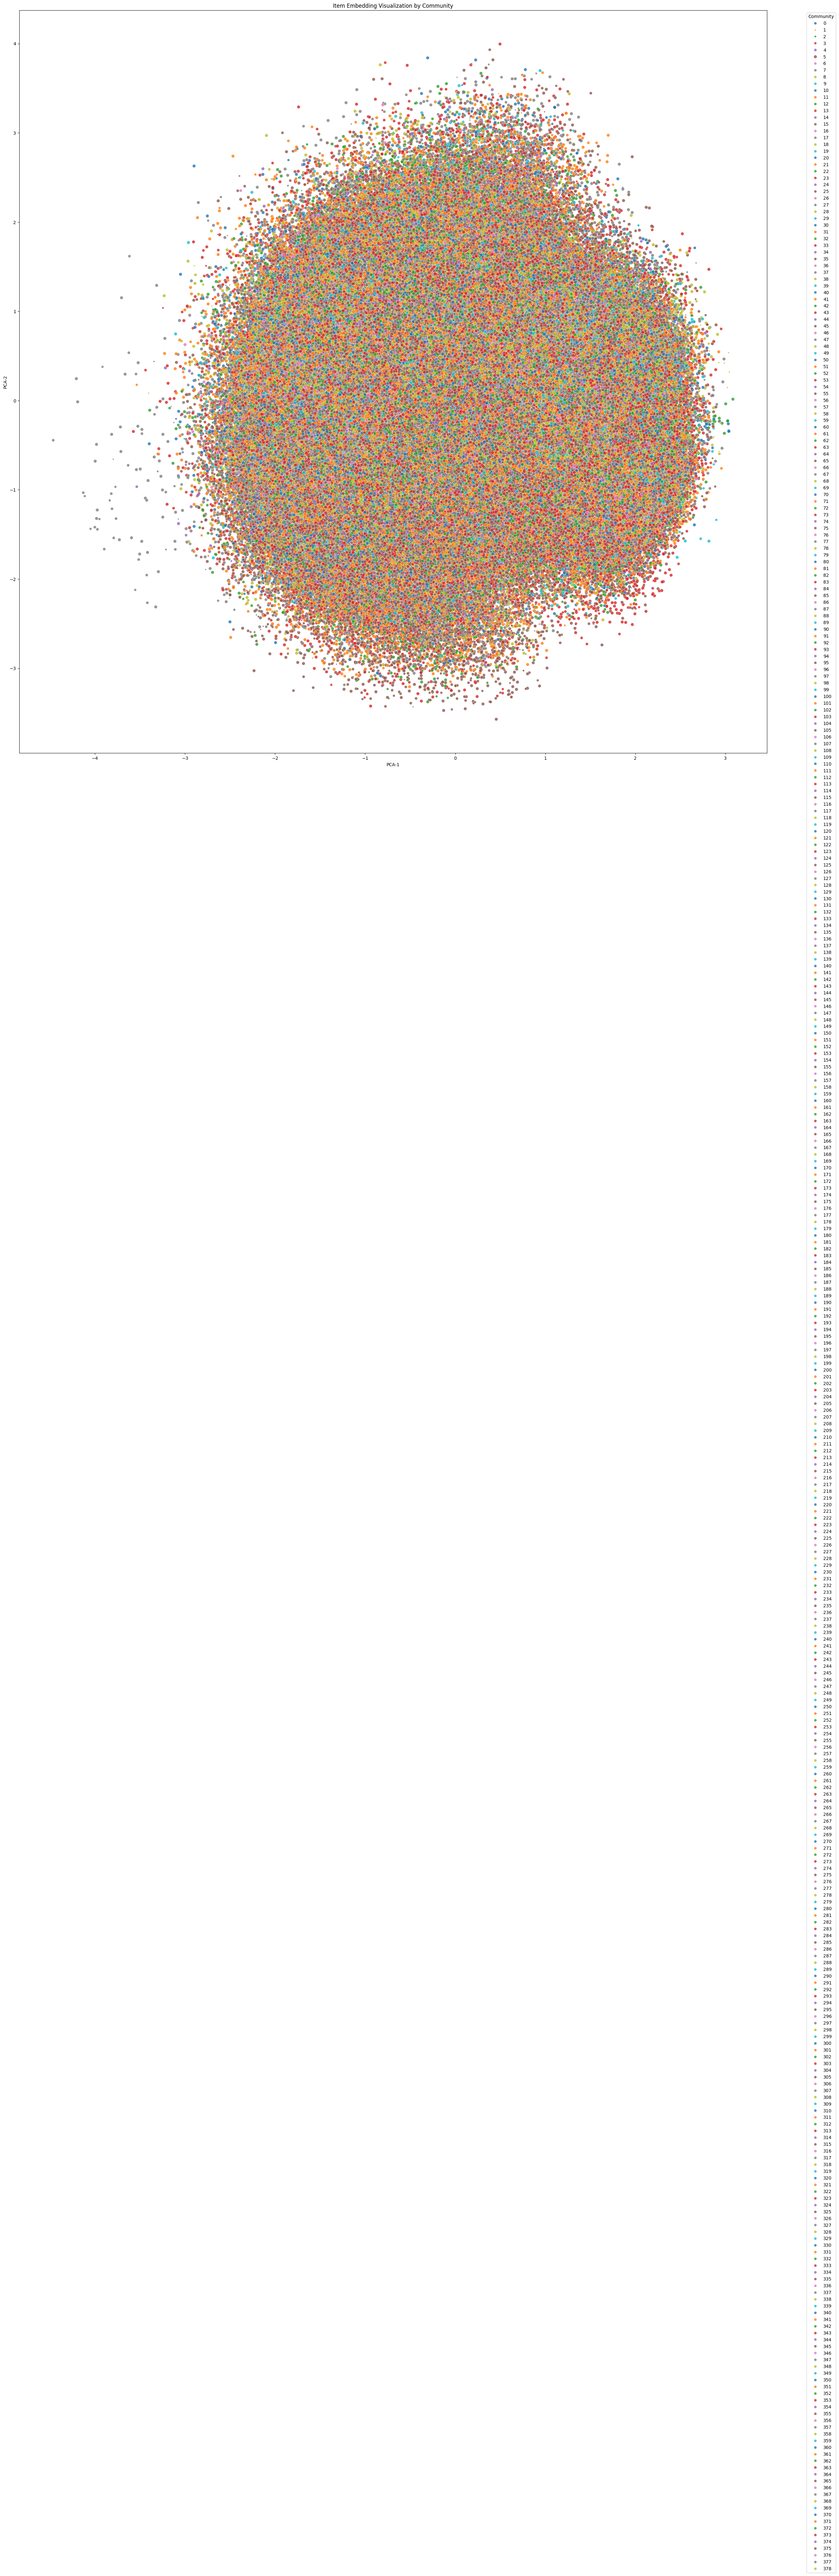

In [23]:
# Visualize item embedding distribution
item_labels = df['comm_idx'].values
ratings = df['rating'].values
pca = PCA(n_components=2)
emb_2d = pca.fit_transform(item_emb_matrix.cpu())

plt.figure(figsize=(30, 30))
sns.scatterplot(x=emb_2d[:, 0], y=emb_2d[:, 1], hue=item_labels, size=ratings,
                sizes=(10, 50), palette='tab10', alpha=0.8)
plt.title("Item Embedding Visualization by Community")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.legend(title='Community', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [94]:
# Define recommendation Model
user_idx = LabelEncoder().fit_transform(df['user_id'])
item_idx = LabelEncoder().fit_transform(df['business_id'])
comm_idx = df['comm_idx'].values
rating_scaled = MinMaxScaler().fit_transform(df['rating'].values.reshape(-1, 1)).squeeze()

user_tensor = torch.tensor(user_idx)
item_tensor = torch.tensor(item_idx)
comm_tensor = torch.tensor(comm_idx)
label_tensor = torch.tensor(rating_scaled, dtype=torch.float32)

class RecommenderWithGATCommunity(nn.Module):
    def __init__(self, n_users, item_emb_matrix, n_comms, meta_dim):
        super().__init__()
        self.item_emb_matrix = item_emb_matrix
        self.u_emb = nn.Embedding(n_users, 32)
        self.c_emb = nn.Embedding(n_comms, 8)
        self.text_proj = nn.Linear(meta_dim // 2, meta_dim)
        self.img_proj = nn.Linear(meta_dim // 2, meta_dim)
        self.attn = nn.MultiheadAttention(meta_dim, 4, batch_first=True)
        self.norm = nn.LayerNorm(meta_dim)
        self.mlp = nn.Sequential(
            nn.Linear(32 + 32 + 8 + meta_dim + meta_dim, 128),
            nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, u, i, c, meta):
        u_vec = self.u_emb(u)
        i_vec = self.item_emb_matrix[i]
        c_vec = self.c_emb(c)
        t, v = meta[:, :meta.shape[1]//2], meta[:, meta.shape[1]//2:]
        t_proj = self.text_proj(t)
        v_proj = self.img_proj(v)
        attn_out, _ = self.attn(t_proj.unsqueeze(1), v_proj.unsqueeze(1), v_proj.unsqueeze(1))
        attn_out = self.norm(attn_out.squeeze(1) + t_proj)
        x = torch.cat([u_vec, i_vec, c_vec, t_proj, attn_out], dim=1)
        return self.mlp(x).squeeze()

In [95]:
# Train and validation
# Prepare Dataset (Saved on CPU)
train_idx, val_idx = train_test_split(np.arange(len(label_tensor)), test_size=0.2, random_state=42)

train_ds = TensorDataset(
    user_tensor[train_idx].cpu(),
    item_tensor[train_idx].cpu(),
    comm_tensor[train_idx].cpu(),
    meta_tensor[train_idx].cpu(),
    label_tensor[train_idx].cpu()
)
val_ds = TensorDataset(
    user_tensor[val_idx].cpu(),
    item_tensor[val_idx].cpu(),
    comm_tensor[val_idx].cpu(),
    meta_tensor[val_idx].cpu(),
    label_tensor[val_idx].cpu()
)

train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=1024, shuffle=False, pin_memory=True, num_workers=0)


In [96]:
# Initialize the model
model = RecommenderWithGATCommunity(
    n_users=len(np.unique(user_idx)),
    item_emb_matrix=item_emb_matrix,
    n_comms=len(np.unique(comm_idx)),
    meta_dim=meta_tensor.shape[1]
).to(DEVICE)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scaler = torch.cuda.amp.GradScaler()


<ipython-input-96-ee555eec893d>:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [97]:
# Training Loop
best_rmse = float('inf')
patience = 3  # Early stopping patience
trigger_times = 0

train_losses = []
val_rmses = []

for epoch in range(1, 51):
    model.train()
    running_loss = 0.0

    train_bar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)  # tqdm: Display training progress
    for u, i, c, meta, y in train_bar:
        u, i, c, meta, y = u.to(DEVICE), i.to(DEVICE), c.to(DEVICE), meta.to(DEVICE), y.to(DEVICE)

        optimizer.zero_grad()
        with torch.autocast(device_type='cuda'):
            pred = model(u, i, c, meta)
            loss = criterion(pred, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    preds, truths = [], []
    with torch.no_grad():
        val_bar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
        for u, i, c, meta, y in val_bar:
            u, i, c, meta, y = u.to(DEVICE), i.to(DEVICE), c.to(DEVICE), meta.to(DEVICE), y.to(DEVICE)
            out = model(u, i, c, meta).cpu().numpy()
            preds.append(out)
            truths.append(y.cpu().numpy())

    preds = np.concatenate(preds)
    truths = np.concatenate(truths)
    rmse = np.sqrt(mean_squared_error(truths, preds))
    val_rmses.append(rmse)

    print(f"Epoch {epoch} Summary: Train Loss = {avg_train_loss:.4f}, Val RMSE = {rmse:.4f}")

    # Early Stopping
    if rmse < best_rmse:
        best_rmse = rmse
        trigger_times = 0
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print(f"Early stopping triggered after {patience} bad epochs.")
            break


Epoch 1 Summary: Train Loss = 0.0544, Val RMSE = 0.2148


Epoch 2 Summary: Train Loss = 0.0348, Val RMSE = 0.1894


Epoch 3 Summary: Train Loss = 0.0283, Val RMSE = 0.1695


Epoch 4 Summary: Train Loss = 0.0251, Val RMSE = 0.1536


Epoch 5 Summary: Train Loss = 0.0234, Val RMSE = 0.1504


Epoch 6 Summary: Train Loss = 0.0219, Val RMSE = 0.1512


Epoch 7 Summary: Train Loss = 0.0206, Val RMSE = 0.1544


Epoch 8 Summary: Train Loss = 0.0191, Val RMSE = 0.1493


Epoch 9 Summary: Train Loss = 0.0177, Val RMSE = 0.1500


Epoch 10 Summary: Train Loss = 0.0164, Val RMSE = 0.1508


Epoch 11 Summary: Train Loss = 0.0153, Val RMSE = 0.1500
Early stopping triggered after 3 bad epochs.


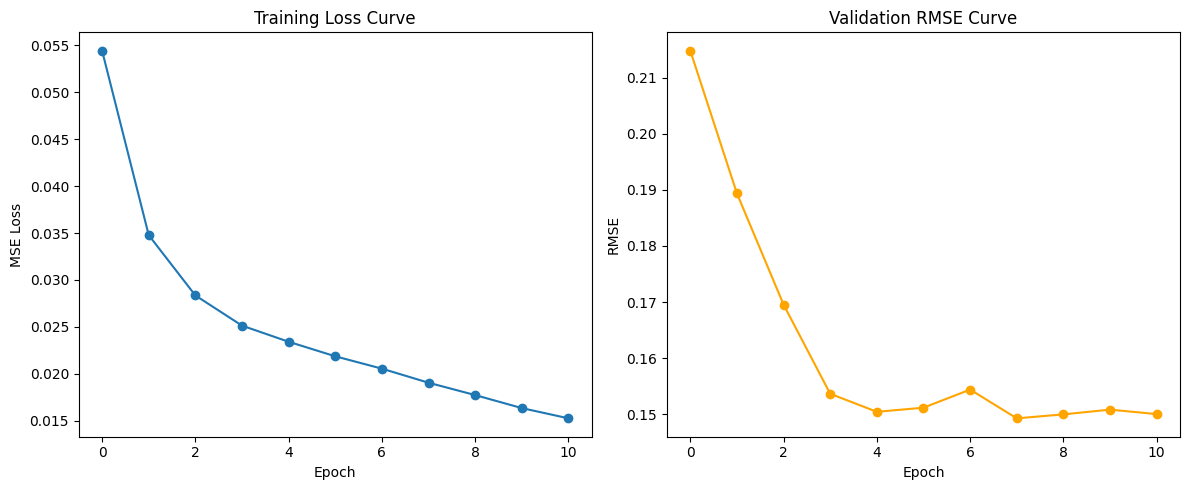

In [98]:
# Plot Training Curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, marker='o')
plt.title('Training Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')

plt.subplot(1, 2, 2)
plt.plot(val_rmses, marker='o', color='orange')
plt.title('Validation RMSE Curve')
plt.xlabel('Epoch')
plt.ylabel('RMSE')

plt.tight_layout()
plt.show()


In [101]:
def evaluate_model_user_item_sampled(
    model,
    user_tensor,
    item_tensor,
    comm_tensor,
    meta_tensor,
    label_tensor,
    K=50,
    user_sample_size=10000,
    max_neg_per_user=1000,
    rating_threshold=3
):
    model.eval()

    if label_tensor.max() <= 1.0:
        print("[Warning] label_tensor appears normalized (max <= 1). Please ensure you are passing original ratings!")

    valid_users = user_tensor[label_tensor >= rating_threshold].unique().cpu().numpy()
    sampled_users = np.random.choice(valid_users, size=min(user_sample_size, len(valid_users)), replace=False)

    precision_list, recall_list, ndcg_list = [], [], []

    all_item_ids = item_tensor.cpu().numpy()
    print(f"Evaluating performance (user_sample={len(sampled_users)}, max_neg_per_user={max_neg_per_user}, threshold={rating_threshold})...")

    empty_user_count = 0

    for u in tqdm(sampled_users, desc="Evaluating Users"):
        ground_truth_items = item_tensor[(user_tensor == u) & (label_tensor >= rating_threshold)].cpu().numpy()

        if len(ground_truth_items) == 0:
            empty_user_count += 1
            continue

        # Dynamic negative sampling number = number of positive samples × 50, capped to max_neg_per_user
        neg_num = min(len(ground_truth_items) * 50, max_neg_per_user)

        neg_pool = list(set(all_item_ids) - set(ground_truth_items))
        if len(neg_pool) == 0:
            continue  # Prevent the negative sample pool from being empty

        sampled_negatives = np.random.choice(neg_pool, size=min(neg_num, len(neg_pool)), replace=False)

        candidates = np.concatenate([ground_truth_items, sampled_negatives])
        candidates_tensor = torch.tensor(candidates, dtype=torch.long)

        u_batch = torch.full((len(candidates_tensor),), u, dtype=torch.long).to(DEVICE)
        i_batch = candidates_tensor.to(DEVICE)
        c_batch = comm_tensor[candidates_tensor].to(DEVICE)
        meta_batch = meta_tensor[candidates_tensor].to(DEVICE)

        with torch.no_grad():
            scores = model(u_batch, i_batch, c_batch, meta_batch).cpu().numpy()

        ranked_indices = np.argsort(-scores)
        ranked_candidates = candidates[ranked_indices]

        precision = precision_at_k(ranked_candidates, ground_truth_items, K)
        recall = recall_at_k(ranked_candidates, ground_truth_items, K)
        ndcg = ndcg_at_k(ranked_candidates, ground_truth_items, K)

        precision_list.append(precision)
        recall_list.append(recall)
        ndcg_list.append(ndcg)

    if len(precision_list) == 0:
        print("[Warning] No valid users with ground truth found! Cannot compute metrics.")
        return np.nan, np.nan, np.nan

    avg_precision = np.mean(precision_list)
    avg_recall = np.mean(recall_list)
    avg_ndcg = np.mean(ndcg_list)

    print(f"\nSampled Evaluation Results (K={K}):")
    print(f"Precision@{K}: {avg_precision:.4f}")
    print(f"Recall@{K}: {avg_recall:.4f}")
    print(f"NDCG@{K}: {avg_ndcg:.4f}")
    print(f"Skipped {empty_user_count} users with no valid ground truth.")

    return avg_precision, avg_recall, avg_ndcg, precision_list, recall_list, ndcg_list


In [102]:
precision, recall, ndcg, precision_list, recall_list, ndcg_list = evaluate_model_user_item_sampled(
    model,
    user_tensor,
    item_tensor,
    comm_tensor,
    meta_tensor,
    torch.tensor(df['rating'].values),  # Notice: the original rating is passed
    K=50,
    user_sample_size=10000,
    max_neg_per_user=1000,  # Dynamic negative sampling upper limit
    rating_threshold=3
)


Evaluating performance (user_sample=10000, max_neg_per_user=1000, threshold=3)...


Evaluating Users: 100%|██████████| 10000/10000 [13:50<00:00, 12.04it/s]


Sampled Evaluation Results (K=50):
Precision@50: 0.0196
Recall@50: 0.7650
NDCG@50: 0.2074
Skipped 0 users with no valid ground truth.


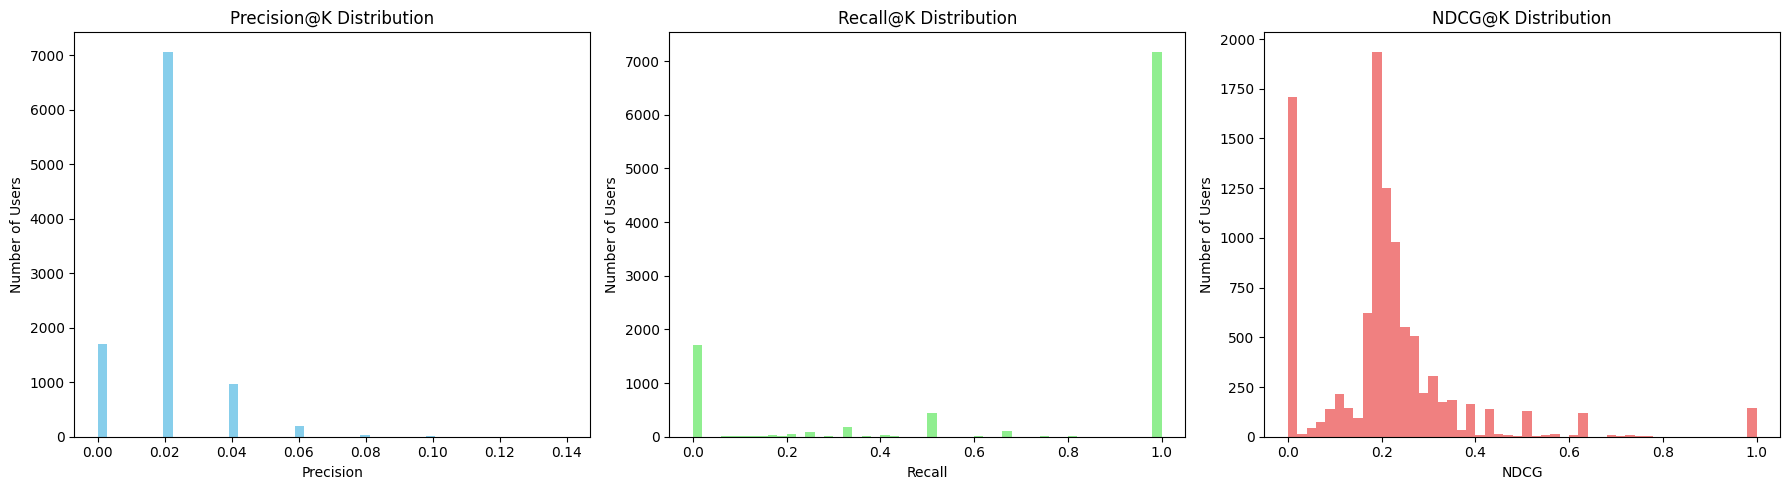

In [103]:
# Plot evaluation results
plt.figure(figsize=(18,5))

plt.subplot(1,3,1)
plt.hist(precision_list, bins=50, color='skyblue')
plt.title("Precision@K Distribution")
plt.xlabel("Precision")
plt.ylabel("Number of Users")

plt.subplot(1,3,2)
plt.hist(recall_list, bins=50, color='lightgreen')
plt.title("Recall@K Distribution")
plt.xlabel("Recall")
plt.ylabel("Number of Users")

plt.subplot(1,3,3)
plt.hist(ndcg_list, bins=50, color='lightcoral')
plt.title("NDCG@K Distribution")
plt.xlabel("NDCG")
plt.ylabel("Number of Users")

plt.tight_layout()
plt.show()